In [1]:
import metrics as me

import anndata as ad
import episcanpy as epi
import scanpy as sc

import numpy as np 
import pandas as pd

from plot_metrics_paired_data import metric_heatmap
from metrics_paired_data import norm_metrics

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

### batch metrics are
- graph_connectivity
- ASW_label/batch
- iLisi_k50
- kbet

### biological conservation are 
- ARI
- AMI
- homogeneity
- ASW_label
- NMI

### paired measures are
- accuracy
- pairwise distance

# Load metrics

In [2]:
df_metrics_skin =pd.read_csv("./final_metrics/metrics_skin_mo_integration_4.csv", index_col=0)

del df_metrics_skin['pairwise_distance_barcode_euclidean_absolute']
del df_metrics_skin['isolated_label_F1'], df_metrics_skin['isolated_label_silhouette']


In [3]:
df_metrics_brain =pd.read_csv("./final_metrics/metrics_brain_mo_integration_4.csv", index_col=0)

del df_metrics_brain['pairwise_distance_barcode_euclidean_absolute']
del df_metrics_brain['isolated_label_F1_broad_cell_type_annotation'], df_metrics_brain['isolated_label_silhouette_broad_cell_type_annotation']
del df_metrics_brain['isolated_label_F1_paper_cell_type'], df_metrics_brain['isolated_label_silhouette_paper_cell_type']

# split broad annotations and paper cell types
df_brain_broad = df_metrics_brain.copy()
del df_brain_broad['ARI_paper_cell_type'], df_brain_broad['AMI_paper_cell_type']
del df_brain_broad['homogeneity_paper_cell_type'], df_brain_broad['graph_connectivity_paper_cell_type']
del df_brain_broad['ASW_label_paper_cell_type'], df_brain_broad['ASW_label/batch_paper_cell_type']

del df_brain_broad['nmi_paper_cell_type']
del df_brain_broad['paper_cell_type_iLisi_k50'], df_brain_broad['paper_cell_type_cLisi_k50']
del df_brain_broad['paper_cell_type_cLisi_k100'], df_brain_broad['paper_cell_type_iLisi_k100']
del df_brain_broad['accuracy_louvain_19']
df_brain_broad.to_csv("./final_metrics/metrics_brain_mo_integration_4_broad_cell_type.csv")

# split broad annotations and paper cell types
df_brain_cell_type = df_metrics_brain.copy()
del df_brain_cell_type['ARI_broad_cell_type'], df_brain_cell_type['AMI_broad_cell_type']
del df_brain_cell_type['homogeneity_broad_cell_type'], df_brain_cell_type['graph_connectivity_broad_cell_type_annotation']
del df_brain_cell_type['ASW_label_broad_cell_type_annotation'], df_brain_cell_type['ASW_label/batch_broad_cell_type_annotation']

del df_brain_cell_type['nmi_broad_cell_type_annotation']
del df_brain_cell_type['broad_cell_type_annotation_iLisi_k50'], df_brain_cell_type['broad_cell_type_annotation_cLisi_k50']
del df_brain_cell_type['accuracy_louvain_7']

del df_brain_cell_type['paper_cell_type_iLisi_k100'], df_brain_cell_type['paper_cell_type_cLisi_k100']
df_brain_cell_type.to_csv("./final_metrics/metrics_brain_mo_integration_4_paper_cell_type.csv")


In [4]:
### renaming columns
columns = ['ARI', 'AMI', 'homogeneity', 'graph_connectivity', 'ASW_label', 'ASW_label/batch',
           'NMI', 'iLisi', 'cLisi', 'accuracy', 'pairwise_distance']

df_brain_cell_type.columns = df_metrics_skin.columns = df_brain_broad.columns = columns



In [5]:
df_brain_cell_type

,ARI,AMI,homogeneity,graph_connectivity,ASW_label,ASW_label/batch,NMI,iLisi,cLisi,accuracy,pairwise_distance
Unintegrated_brain,0.128189,0.400358,0.370842,0.791094,0.370600,0.176706,0.406641,2.220446e-16,-0.388101,0.020491,1.038223
Seurat brain,0.289797,0.384040,0.387959,0.775465,0.473217,0.601727,0.389809,1.284701e-02,-0.804222,0.349891,0.774401
Liger_brain,0.234489,0.329617,0.342542,0.627211,0.445416,0.434691,0.335698,4.789779e-01,-0.320316,0.221981,1.038223


In [6]:
## adding kbet

kbet_df = pd.read_csv("metrics_mo_integration_kbet.csv", index_col=0)
for n in [ 'ARI', 'AMI', 'HOMO', 'SIL', 'NMI', 'iLISI_knn',
       'cLISI_knn', 'iLISI_full_50', 'cLISI_full_50', 'iLISI_full_100',
       'cLISI_full_100']:
    del kbet_df[n]
kbet_average = {}
for name in kbet_df.index.tolist():
    kbet_list = kbet_df.loc[name,:].tolist()[0]
    kbet_list = kbet_list.split('\n')[1:]
    kbet_list = [x.split(" ") for x in kbet_list]
    kbet_dict = {}
    tmp_list = []
    for n in kbet_list:
        
        if n[-1] == "NaN":
            kbet_dict[n[-8]] = float(n[-1])
        else:
            tmp_list.append(float(n[-1]))
            kbet_dict[n[-3]] = float(n[-1])
            
    kbet_average[name]=np.mean(tmp_list)
    
df_brain_cell_type['kbet'] = [kbet_average['Unintegrated_brain'],
                                          kbet_average['Seurat_brain'],
                                         kbet_average['Unintegrated_brain']]
df_metrics_skin['kbet'] = [kbet_average['Unintegrated_skin'],
                                          kbet_average['Seurat_skin'],
                                         kbet_average['Unintegrated_skin']]

In [7]:
### sorting dataframe columns
sorted_columns = ['iLisi', 'ASW_label/batch', 'graph_connectivity', 'kbet',
                  'ARI', 'AMI', 'NMI', 'homogeneity', 'ASW_label', 'cLisi',
                  'accuracy', 'pairwise_distance']

df_brain_cell_type = df_brain_cell_type.reindex(sorted_columns[::-1], axis=1)
df_metrics_skin = df_metrics_skin.reindex(sorted_columns[::-1], axis=1)

sorted_columns_broad = ['iLisi', 'ASW_label/batch', 'graph_connectivity', #'kbet',
                  'ARI', 'AMI', 'NMI', 'homogeneity', 'ASW_label', 'cLisi',
                  'accuracy', 'pairwise_distance']
df_brain_broad = df_brain_broad.reindex(sorted_columns_broad[::-1], axis=1)

In [8]:
df_brain_cell_type

,pairwise_distance,accuracy,cLisi,ASW_label,homogeneity,NMI,AMI,ARI,kbet,graph_connectivity,ASW_label/batch,iLisi
Unintegrated_brain,1.038223,0.020491,-0.388101,0.370600,0.370842,0.406641,0.400358,0.128189,0.726604,0.791094,0.176706,2.220446e-16
Seurat brain,0.774401,0.349891,-0.804222,0.473217,0.387959,0.389809,0.384040,0.289797,0.846399,0.775465,0.601727,1.284701e-02
Liger_brain,1.038223,0.221981,-0.320316,0.445416,0.342542,0.335698,0.329617,0.234489,0.726604,0.627211,0.434691,4.789779e-01


# Normalise metrics

In [9]:
df_brain_cell_type_scaled = norm_metrics(df_brain_cell_type)
df_brain_broad_scaled = norm_metrics(df_brain_broad)
df_metrics_skin_scaled = norm_metrics(df_metrics_skin)

In [10]:
df_metrics_skin_scaled

,pairwise_distance,accuracy,cLisi,ASW_label,homogeneity,NMI,AMI,ARI,kbet,graph_connectivity,ASW_label/batch,iLisi
Unintegrated_skin,1.124602,0.005222,0.473119,0.723806,0.384606,0.396064,0.395227,0.206415,0.530552,0.738102,0.599275,0.000000e+00
Seurat_skin,0.786066,0.546913,0.561949,0.739445,0.533132,0.506555,0.505931,0.296073,0.782324,0.761710,0.939514,4.440892e-16
Liger_skin,1.124602,0.209296,0.300546,0.721212,0.334962,0.317753,0.316893,0.150963,0.530552,0.622637,0.808021,5.332940e-01


In [11]:
df_brain_broad_scaled

,pairwise_distance,accuracy,cLisi,ASW_label,homogeneity,NMI,AMI,ARI,graph_connectivity,ASW_label/batch,iLisi
Unintegrated_brain,1.038223,0.055883,0.817995,0.685300,0.306331,0.306168,0.304731,0.136150,0.878769,0.588353,2.220446e-16
Seurat brain,0.774401,0.591431,0.791446,0.736609,0.345900,0.323969,0.322671,0.297086,0.881143,0.800863,1.284701e-02
Liger_brain,1.038223,0.425334,0.846950,0.722708,0.207014,0.203316,0.201705,0.292272,0.674820,0.717345,4.789779e-01


In [12]:
df_brain_cell_type_scaled

,pairwise_distance,accuracy,cLisi,ASW_label,homogeneity,NMI,AMI,ARI,kbet,graph_connectivity,ASW_label/batch,iLisi
Unintegrated_brain,1.038223,0.020491,0.305949,0.685300,0.370842,0.406641,0.400358,0.128189,0.726604,0.791094,0.588353,2.220446e-16
Seurat brain,0.774401,0.349891,0.097889,0.736609,0.387959,0.389809,0.384040,0.289797,0.846399,0.775465,0.800863,1.284701e-02
Liger_brain,1.038223,0.221981,0.339842,0.722708,0.342542,0.335698,0.329617,0.234489,0.726604,0.627211,0.717345,4.789779e-01


## Plotting metrics

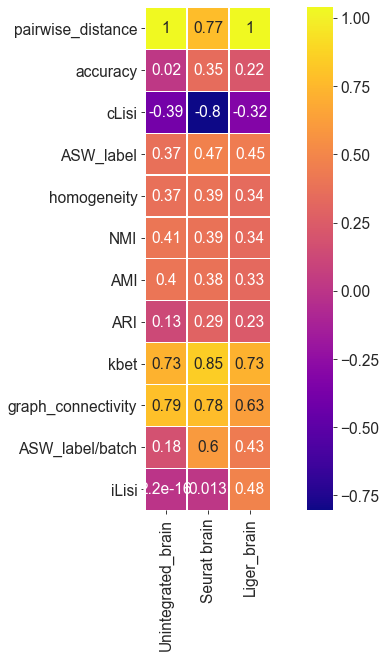

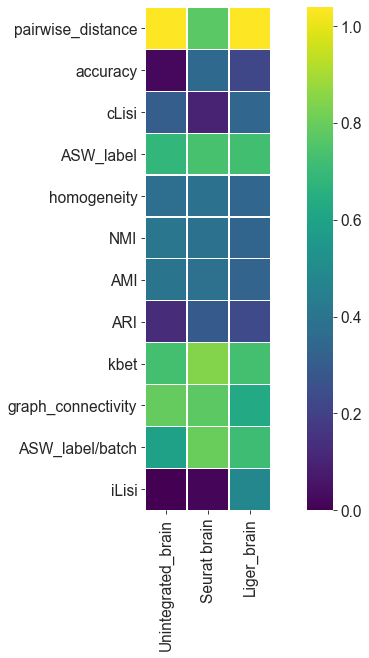

In [13]:
# brain cell type raw
metric_heatmap(df_brain_cell_type,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_raw.png")
metric_heatmap(df_brain_cell_type,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_raw.pdf")

# brain cell type scaled
metric_heatmap(df_brain_cell_type_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_scaled.png")
metric_heatmap(df_brain_cell_type_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_scaled.pdf")

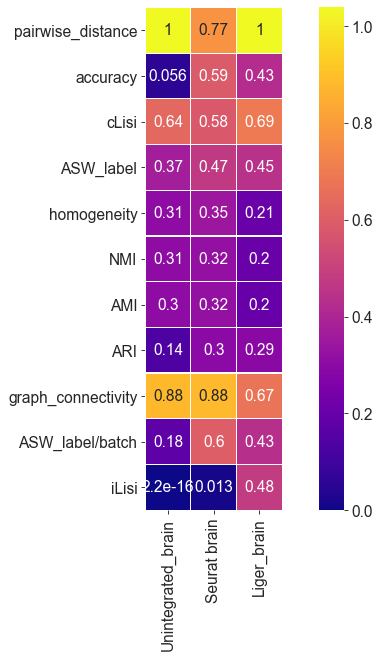

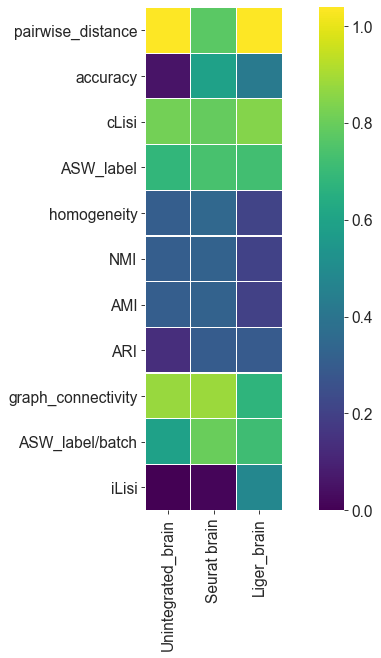

In [14]:
# brain broad annotations raw
metric_heatmap(df_brain_broad,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_broad_raw.png")
metric_heatmap(df_brain_broad,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_broad_raw.pdf")

# brain broad annotations scaled
metric_heatmap(df_brain_broad_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_broad_scaled.png")
metric_heatmap(df_brain_broad_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_broad_scaled.pdf")

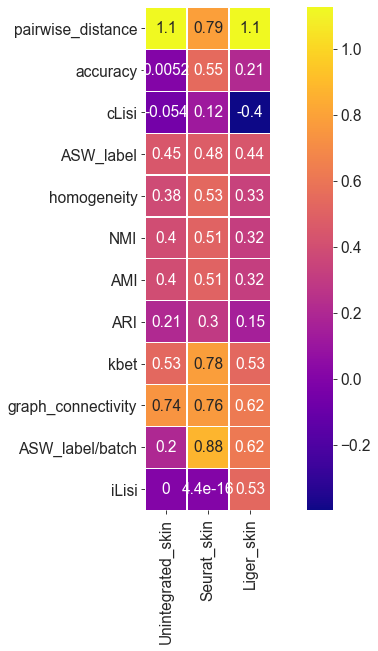

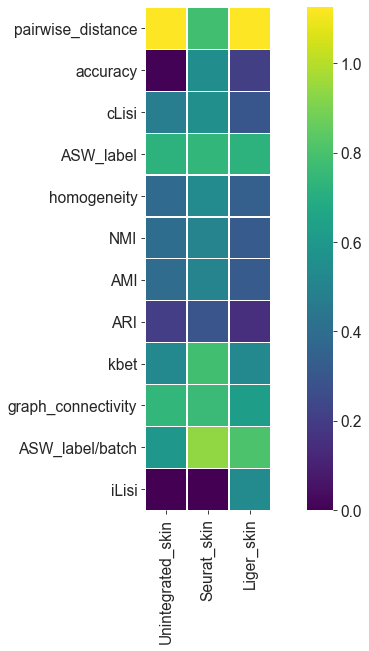

In [15]:
# skin raw
metric_heatmap(df_metrics_skin,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=True,
               save="./figure_metric_heatmaps/metrics_skin_raw.png")
metric_heatmap(df_metrics_skin,
               cmap='plasma',
               scale=False,
               display_values=True,
               show=False,
               save="./figure_metric_heatmaps/metrics_skin_raw.pdf")

# skin scaled
metric_heatmap(df_metrics_skin_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_skin_scaled.png")
metric_heatmap(df_metrics_skin_scaled,
               cmap='viridis',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_skin_scaled.pdf")

# save final metrics

In [32]:
df_brain_broad
df_brain_broad.to_csv("raw_metrics_brain_mo_integration_broad_cell_types.csv")

In [33]:
df_brain_cell_type
df_brain_cell_type.to_csv("raw_metrics_brain_mo_integration_cell_types.csv")

In [34]:
df_metrics_skin
df_metrics_skin.to_csv("raw_metrics_skin_mo_integration_cell_types.csv")

### funny plots easter egg

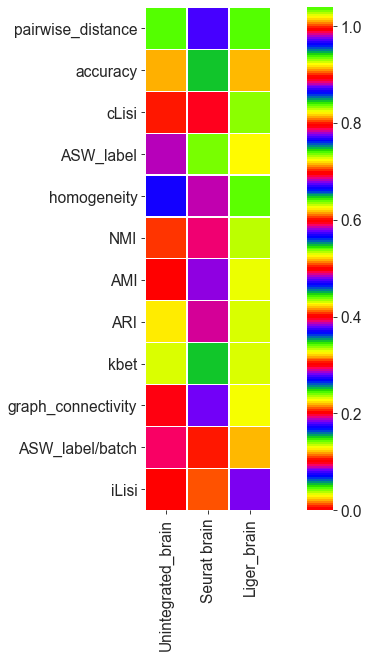

In [17]:
# brain cell type scaled
metric_heatmap(df_brain_cell_type_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_scaled_easter_egg.png")
metric_heatmap(df_brain_cell_type_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_cell_type_scaled_easter_egg.pdf")

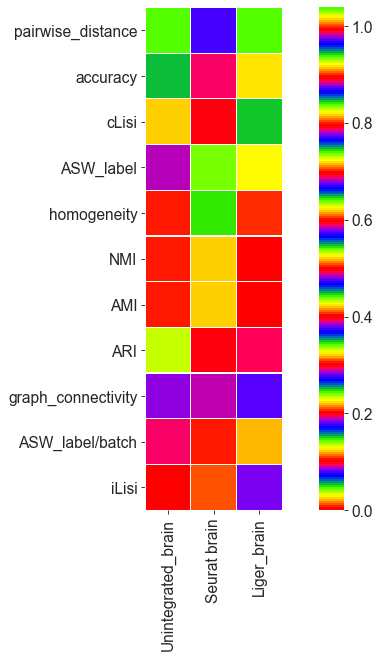

In [18]:
# brain broad annotations scaled
metric_heatmap(df_brain_broad_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_brain_broad_scaled_easter_egg.png")
metric_heatmap(df_brain_broad_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_brain_broad_scaled_easter_egg.pdf")

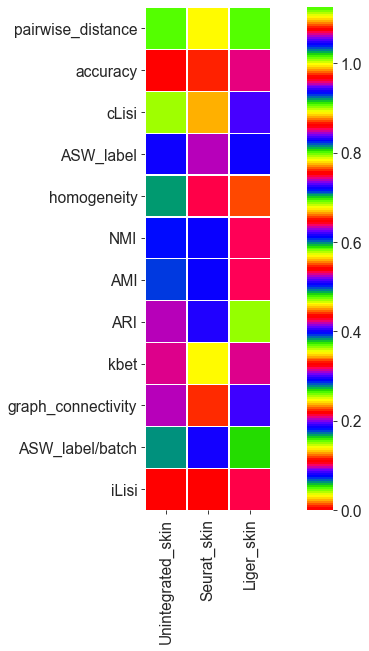

In [19]:
# skin scaled
metric_heatmap(df_metrics_skin_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=True,
               save="./figure_metric_heatmaps/metrics_skin_scaled_easter_egg.png")
metric_heatmap(df_metrics_skin_scaled,
               cmap='prism',
               scale=False,
               display_values=False,
               show=False,
               save="./figure_metric_heatmaps/metrics_skin_scaled_easter_egg.pdf")